In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath("../../"))

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

In [2]:
from brmspy.brms import bf
from brmspy import brms

In [3]:
if True:
    with brms.manage() as ctx:
        ctx.install_brms(use_prebuilt=True)
        ctx.install_rpackage("MCMCglmm")

if False:
    env = "brms"
    if not brms.environment_exists(env):
        with brms.manage(environment_name=env) as ctx:
            ctx.install_brms(use_prebuilt=True)
            ctx.install_rpackage("MCMCglmm")
    else:
        brms.environment_activate(env)

[brmspy][_autoload] Activating runtime /Users/sebastian/.brmspy/runtime/macos-arm64-r4.5-0.2.0
[brmspy][_autoload] lib paths are ['/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/library', '/Users/sebastian/.brmspy/runtime/macos-arm64-r4.5-0.2.0/Rlib']
[brmspy][_autoload] Setting cmdstan path to /Users/sebastian/.brmspy/runtime/macos-arm64-r4.5-0.2.0/cmdstan
[brmspy][install_brms] Activating runtime /Users/sebastian/.brmspy/runtime/macos-arm64-r4.5-0.2.0
[brmspy][install_brms] lib paths are ['/Users/sebastian/.brmspy/environment/default/Rlib', '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/library', '/Users/sebastian/.brmspy/runtime/macos-arm64-r4.5-0.2.0/Rlib']
[brmspy][install_brms] Setting cmdstan path to /Users/sebastian/.brmspy/runtime/macos-arm64-r4.5-0.2.0/cmdstan
[brmspy][worker_main] MCMCglmm 2.36 already installed.


In [4]:
r_matrix = brms.call(
    "matrix",
    [1,2,3, 11,12,13],
    nrow = 2, ncol = 3,
    byrow = True,
    dimnames = [
        ["row1", "row2"],
        ["C.1", "C.2", "C.3"]
    ]
)

In [5]:
r_matrix

[1, 11, 2, 12, 3, 13]

In [6]:
r_matrix

[1, 11, 2, 12, 3, 13]

In [7]:
data = brms.get_brms_data("epilepsy")
data

,Age,Base,Trt,patient,visit,count,obs,zAge,zBase
1,31.0,11.0,1,1,1,5.0,1,0.424995,-0.757173
2,30.0,11.0,1,2,1,3.0,2,0.265284,-0.757173
3,25.0,6.0,1,3,1,2.0,3,-0.533274,-0.944403
4,36.0,8.0,1,4,1,4.0,4,1.223553,-0.869511
5,22.0,66.0,1,5,1,7.0,5,-1.012408,1.302363
...,...,...,...,...,...,...,...,...,...
232,32.0,16.0,2,55,4,3.0,232,0.584707,-0.569942
233,26.0,22.0,2,56,4,8.0,233,-0.373562,-0.345266
234,21.0,25.0,2,57,4,1.0,234,-1.172120,-0.232927
235,36.0,13.0,2,58,4,0.0,235,1.223553,-0.682281


In [8]:
from brmspy.brms import poisson
formula = bf("count ~ zAge + zBase * Trt + (1|patient)") + poisson()
formula

bf('count ~ zAge + zBase * Trt + (1|patient)') + poisson(link='log')

In [9]:
brms.default_prior(formula, data)

[brmspy][can_encode][WARNING] pd.DataFrame contains Object type columns, falling back to pickle!


,prior,class,coef,group,resp,dpar,nlpar,lb,ub,tag,source
1,,b,,,,,,,,,default
2,,b,Trt,,,,,,,,default
3,,b,zAge,,,,,,,,default
4,,b,zBase,,,,,,,,default
5,,b,zBase:Trt,,,,,,,,default
6,"student_t(3, 4, 4.4)",Intercept,,,,,,,,,default
7,"student_t(3, 0, 4.4)",sd,,,,,,0,,,default
8,,sd,,patient,,,,,,,default
9,,sd,Intercept,patient,,,,,,,default
10,"student_t(3, 0, 4.4)",sigma,,,,,,0,,,default


In [10]:

r1 = brms.brm(
    formula=bf("count ~ zAge + zBase * Trt + (1|patient)") + poisson(),
    data=data,
    warmup=500,
    iter=1000,
    chains=4
)


[brmspy][worker_main] Fitting model with brms (backend: cmdstanr)...
[brmspy][worker_main] Fit done!


In [11]:
brms.summary(r1)

 Family: gaussian 
  Links: mu = identity 
Formula: count ~ zAge + zBase * Trt + (1 | patient) 
   Data: structure(list(Age = c(31, 30, 25, 36, 22, 29, 31, (Number of observations: 236) 
  Draws: 4 chains, each with iter = 1000; warmup = 500; thin = 1;
         total post-warmup draws = 2000

Multilevel Hyperparameters:
~patient (Number of levels: 59) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     5.21      0.68     3.98     6.60 1.00      607     1205

Regression Coefficients:
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     8.86      2.68     3.27    14.12 1.01      513      652
zAge          1.64      0.82    -0.06     3.21 1.00      607      546
zBase         2.20      2.65    -2.99     7.61 1.01      529      792
Trt          -0.49      1.69    -3.77     2.94 1.01      506      765
zBase:Trt     4.82      1.63     1.61     8.07 1.01      603      836

Further Distributional Parameters:
      Estimate 

In [12]:
import arviz as az

<Axes: xlabel='count'>

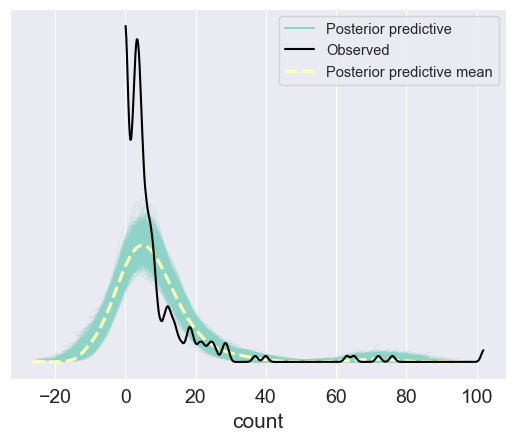

In [13]:
az.plot_ppc(r1.idata)

In [14]:
from brmspy.types.formula_dsl import FormulaConstruct
from brmspy.brms import bernoulli, shifted_lognormal

In [15]:
s = FormulaConstruct._formula_parse("y ~ x")

f = s + 'z ~ b' + 'u ~ v'
u = s + "A"
v = s + "B"


In [16]:
v

bf('y ~ x') + bf('B')